# LAB 2: Random Forest Stuff
### AI and Machine Learning // Suchkova Natalia М8О - 114М - 22
30.04.23 @ MAI IT-Center

### The Task
Построить графики зависимости:

- Метрики качества классификации от кол-ва деревьев.
- Качества обучения от max глубины деревьев

В качетсве датасета взять make_classification или любого простого табличного датасета

In [2]:
import os
import itertools
# from google.colab import files
import zipfile
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


import matplotlib.pyplot as plt
import imutils
import cv2


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

from pathlib import Path
from matplotlib.patches import Rectangle
from scipy.io import loadmat

Ссылка на ноутбук Google Colab - https://colab.research.google.com/drive/1-uyQlVHNqb6VWoHKtjW94xaZ1UBFCZct?usp=sharing

### Можно загрузить датасет прямо из Kaggle

In [2]:
# !pip install -q kaggle

In [3]:
# Используйте приведенный ниже код, чтобы загрузить свой kaggle.json в среду colab (вы можете скачать kaggle.json из вашего профиля->Учетная запись-> Токен API)
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nataliasuchkova","key":"5e7db9b3e4b3fa30ebfd4f3fbfd19d18"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [12]:
!kaggle datasets download -d eduardo4jesus/stanford-cars-dataset

100% 1.82G/1.82G [00:23<00:00, 101MB/s] 
100% 1.82G/1.82G [00:23<00:00, 82.4MB/s]


In [13]:
with zipfile.ZipFile('stanford-cars-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('')

### Исследуем датасет

### Stanford Cars Dataset
https://ai.stanford.edu/~jkrause/cars/car_dataset.html

**Overview**

The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.

**Acknowledgements**

Data source and banner image:
http://ai.stanford.edu/~jkrause/cars/car_dataset.html contains all bounding boxes and labels for both training and tests.

If you use this dataset, please cite the following paper:

3D Object Representations for Fine-Grained Categorization

Jonathan Krause, Michael Stark, Jia Deng, Li Fei-Fei

4th IEEE Workshop on 3D Representation and Recognition, at ICCV 2013 (3dRR-13). Sydney, Australia. Dec. 8, 2013.

In [15]:
devkit_path = Path('car_devkit/devkit')
train_path = Path('cars_train/cars_train')
test_path = Path('cars_test/cars_test')

In [16]:
os.listdir(devkit_path)

['cars_test_annos.mat',
 'train_perfect_preds.txt',
 'cars_train_annos.mat',
 'README.txt',
 'cars_meta.mat',
 'eval_train.m']

In [17]:
cars_meta = loadmat(devkit_path/'cars_meta.mat')
cars_train_annos = loadmat(devkit_path/'cars_train_annos.mat')
cars_test_annos = loadmat(devkit_path/'cars_test_annos.mat')

Loading Labels

In [18]:
labels = [c for c in cars_meta['class_names'][0]]
labels = pd.DataFrame(labels, columns=['labels'])
labels.head()

,labels
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012


Loading Cars TRain

In [19]:
frame = [[i.flat[0] for i in line] for line in cars_train_annos['annotations'][0]]
columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class', 'fname']
df_train = pd.DataFrame(frame, columns=columns)
df_train['class'] = df_train['class']-1 # Python indexing starts on zero.
df_train['fname'] = [train_path/f for f in df_train['fname']] #  Appending Path
df_train.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname
0,39,116,569,375,13,cars_train/cars_train/00001.jpg
1,36,116,868,587,2,cars_train/cars_train/00002.jpg
2,85,109,601,381,90,cars_train/cars_train/00003.jpg
3,621,393,1484,1096,133,cars_train/cars_train/00004.jpg
4,14,36,133,99,105,cars_train/cars_train/00005.jpg


Merge Labels

In [20]:
df_train = df_train.merge(labels, left_on='class', right_index=True)
df_train = df_train.sort_index()
df_train.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname,labels
0,39,116,569,375,13,cars_train/cars_train/00001.jpg,Audi TTS Coupe 2012
1,36,116,868,587,2,cars_train/cars_train/00002.jpg,Acura TL Sedan 2012
2,85,109,601,381,90,cars_train/cars_train/00003.jpg,Dodge Dakota Club Cab 2007
3,621,393,1484,1096,133,cars_train/cars_train/00004.jpg,Hyundai Sonata Hybrid Sedan 2012
4,14,36,133,99,105,cars_train/cars_train/00005.jpg,Ford F-450 Super Duty Crew Cab 2012


Display Images

In [22]:
# Returns (Image, title, rectangle patch) for drawing
def get_assets(df, i):
    is_train = df is df_train
    folder = train_path if is_train else test_path
    image = Image.open(df['fname'][i])
    title = df['labels'][i] if is_train else 'Unclassified'

    xy = df['bbox_x1'][i], df['bbox_y1'][i]
    width = df['bbox_x2'][i] - df['bbox_x1'][i]
    height = df['bbox_y2'][i] - df['bbox_y1'][i]
    rect = Rectangle(xy, width, height, fill=False, color='r', linewidth=2)

    return (image, title, rect)

In [23]:
def display_image(df, i):
    image, title, rect = get_assets(df, i)
    print(title)

    plt.imshow(image)
    plt.axis('off')
    plt.title(title)
    plt.gca().add_patch(rect)

Audi TTS Coupe 2012


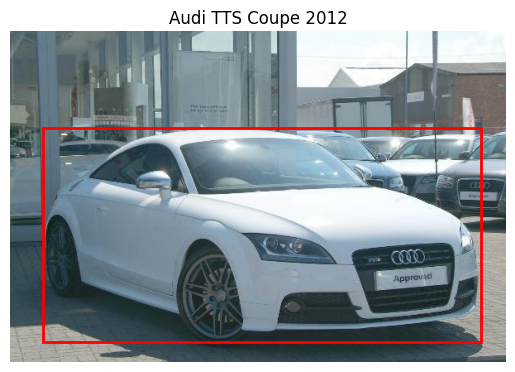

In [24]:
display_image(df_train, 0)

Show Multiple

In [25]:
def display_range(end, start = 0):

    n = end - start
    fig, ax = plt.subplots(n, 2, figsize=(15, 5*end))

    for i in range(start, end):
        line = i - start

        im, title, rect = get_assets(df_train, i)
        sub = ax[line, 0]
        sub.imshow(im)
        sub.axis('off')
        sub.set_title(title)
        sub.add_patch(rect)

        im, title, rect = get_assets(df_test, i)
        sub = ax[line, 1]
        sub.imshow(im)
        sub.axis('off')
        sub.set_title(title)
        sub.add_patch(rect)

    plt.show()

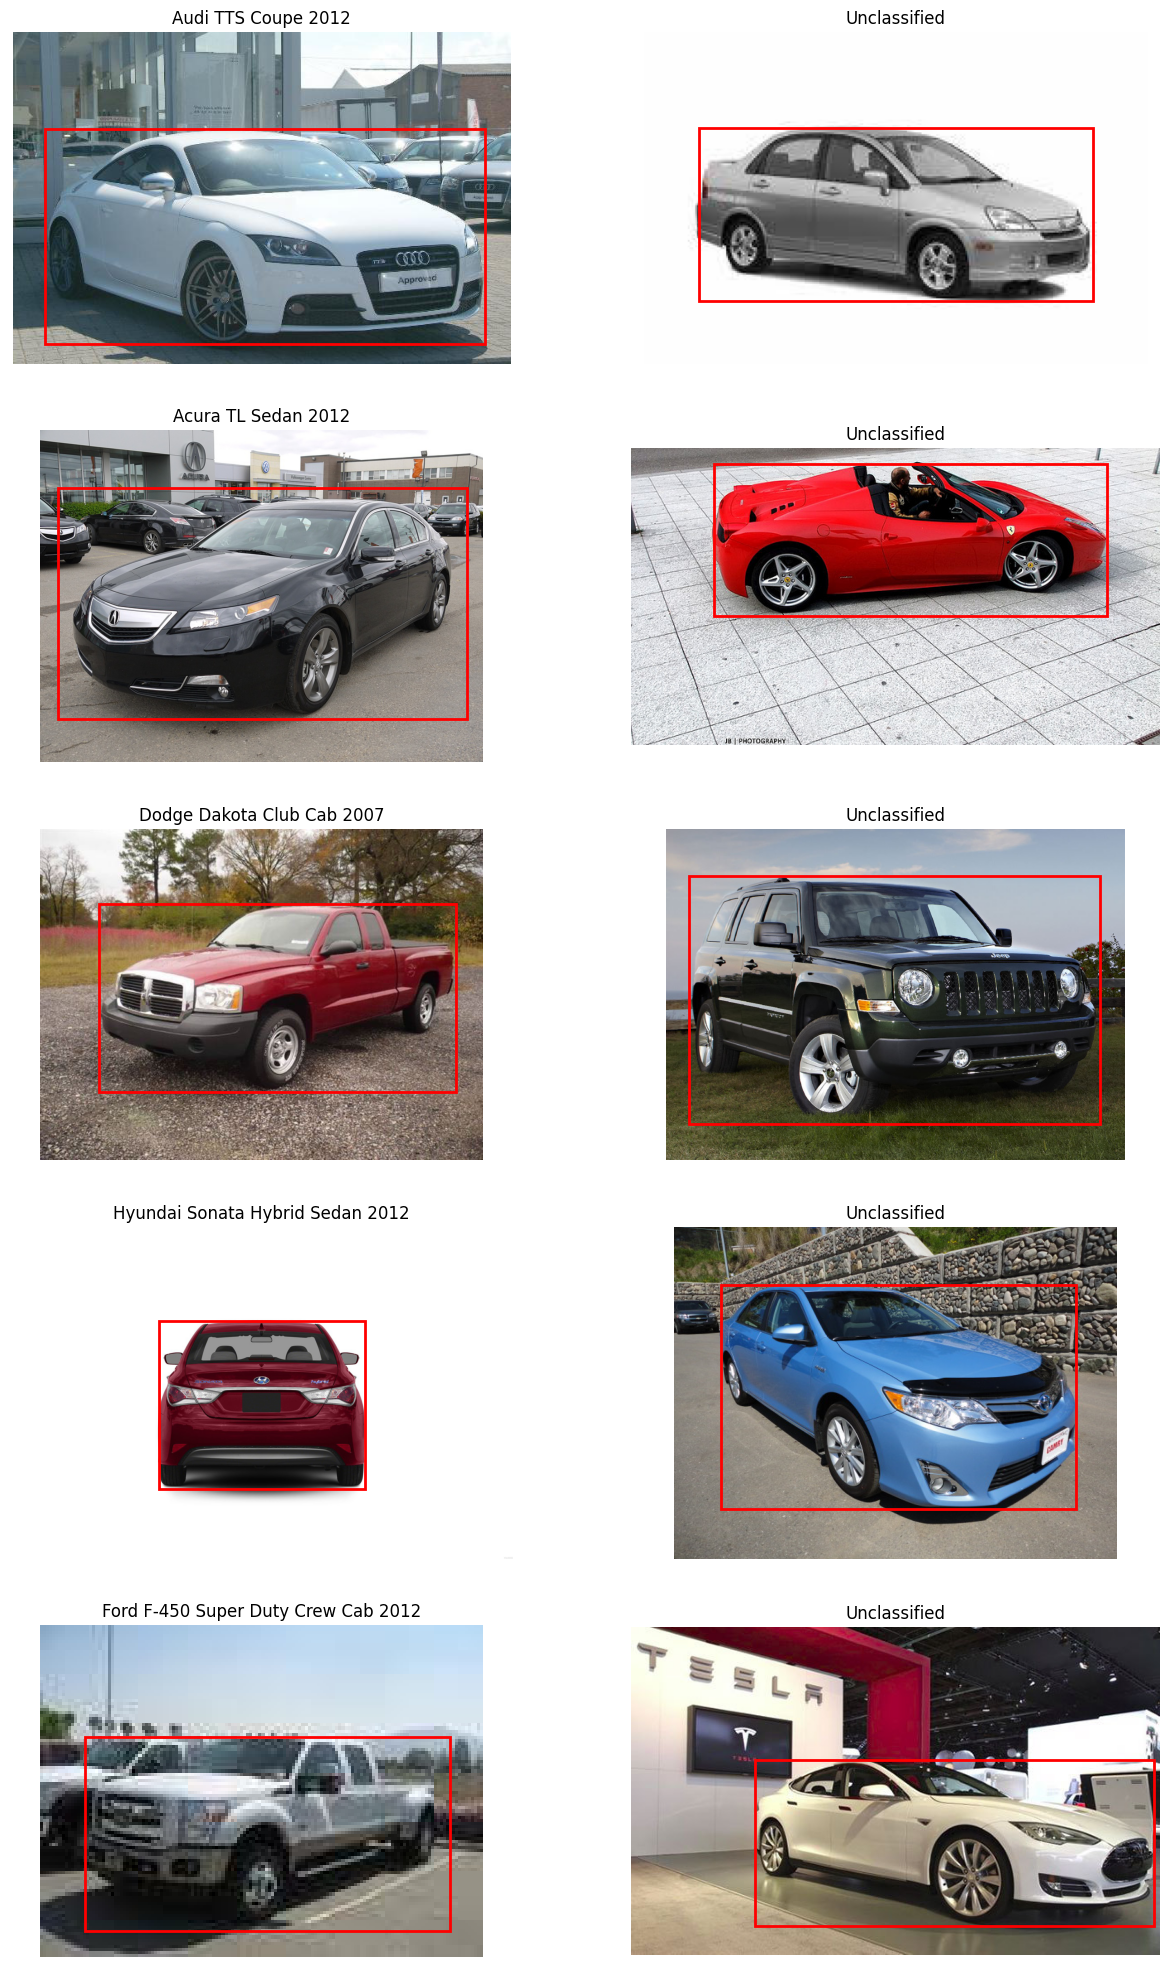

In [26]:
display_range(5)

Model Distribution

In [27]:
freq_labels = df_train.groupby('labels').count()[['class']]
freq_labels = freq_labels.rename(columns={'class': 'count'})
freq_labels = freq_labels.sort_values(by='count', ascending=False)
freq_labels.head()

,count
labels,
GMC Savana Van 2012,68
Chrysler 300 SRT-8 2010,49
Mercedes-Benz 300-Class Convertible 1993,48
Mitsubishi Lancer Sedan 2012,48
Jaguar XK XKR 2012,47


Text(0, 0.5, 'Count')

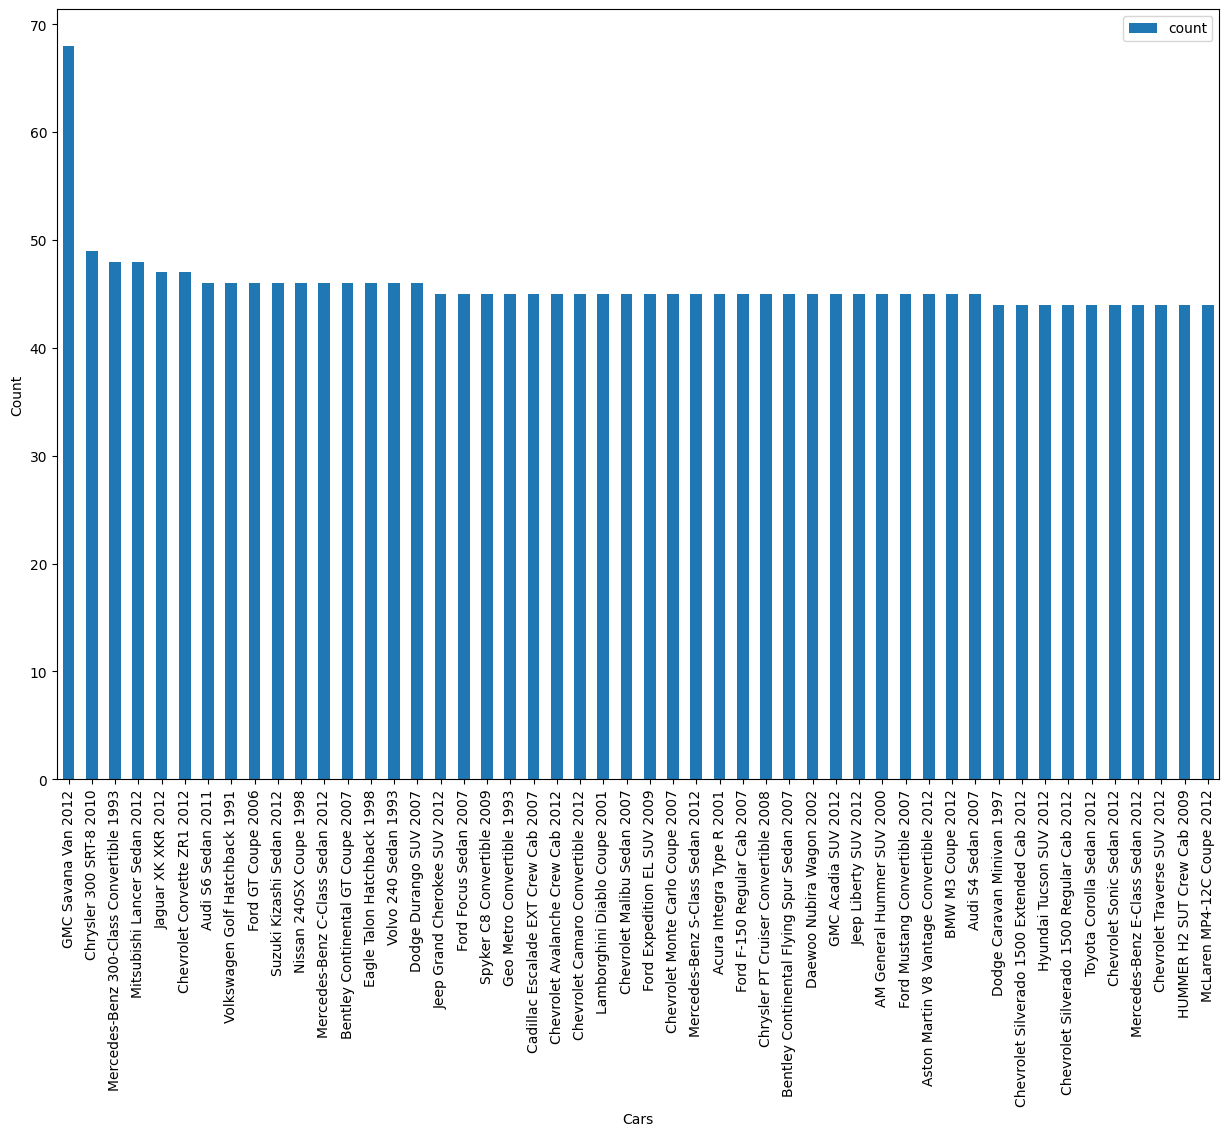

In [28]:
freq_labels.head(50).plot.bar(figsize=(15,10))
plt.xticks(rotation=90)
plt.xlabel("Cars")
plt.ylabel("Count")

In [29]:
df_train.shape

(8144, 7)

In [30]:
df_train

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname,labels
0,39,116,569,375,13,cars_train/cars_train/00001.jpg,Audi TTS Coupe 2012
1,36,116,868,587,2,cars_train/cars_train/00002.jpg,Acura TL Sedan 2012
2,85,109,601,381,90,cars_train/cars_train/00003.jpg,Dodge Dakota Club Cab 2007
3,621,393,1484,1096,133,cars_train/cars_train/00004.jpg,Hyundai Sonata Hybrid Sedan 2012
4,14,36,133,99,105,cars_train/cars_train/00005.jpg,Ford F-450 Super Duty Crew Cab 2012
...,...,...,...,...,...,...,...
8139,3,44,423,336,77,cars_train/cars_train/08140.jpg,Chrysler Town and Country Minivan 2012
8140,138,150,706,523,195,cars_train/cars_train/08141.jpg,smart fortwo Convertible 2012
8141,26,246,660,449,162,cars_train/cars_train/08142.jpg,Mercedes-Benz SL-Class Coupe 2009
8142,78,526,1489,908,111,cars_train/cars_train/08143.jpg,Ford GT Coupe 2006


In [38]:
df_train.dtypes

bbox_x1    uint16
bbox_y1    uint16
bbox_x2    uint16
bbox_y2    uint16
class       uint8
fname      object
labels     object
dtype: object

In [45]:
df_train.fname = df_train.fname.astype(str)

In [39]:
df_train.fname.iloc[3]

'cars_train/cars_train/00004.jpg'

In [ ]:
cv2.imread(df_train.fname.iloc[3]).shape  # (1386, 2100, 3) поэтому езе результаты такие странные

In [ ]:
cv2.imread(df_train.fname.iloc[542]).shape  # (300, 400, 3)

In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(df_train, df_train.labels, test_size=0.2, random_state=0)

In [129]:
def image_to_feature_vector(image, size=(32, 32)):
    return cv2.cvtColor(cv2.resize(image, size), cv2.COLOR_BGR2GRAY).flatten()

In [131]:
rawImages_tr = []
rawImages_tst = []


for path in X_train[:1000].fname:
    image = cv2.imread(path)
    pixels = image_to_feature_vector(image)

    rawImages_tr.append(pixels)

for path in X_test[:200].fname:
    image = cv2.imread(path)
    pixels = image_to_feature_vector(image)

    rawImages_tst.append(pixels)

In [132]:
labels_train = np.array(Y_train[:1000].to_list())
labels_test = np.array(Y_test[:200].to_list())

In [133]:
rawImages_tr = np.array(rawImages_tr)
rawImages_tst = np.array(rawImages_tst)

In [ ]:
def get_score(train_data, test_data, 
              train_labels, test_labels,
              max_depth = None, 
              n_estimators = 100):
    clf = RandomForestClassifier(max_depth=max_depth, n_estimators = n_estimators, random_state=0)
    clf.fit(train_data, train_labels)
    return clf.score(test_data, test_labels)

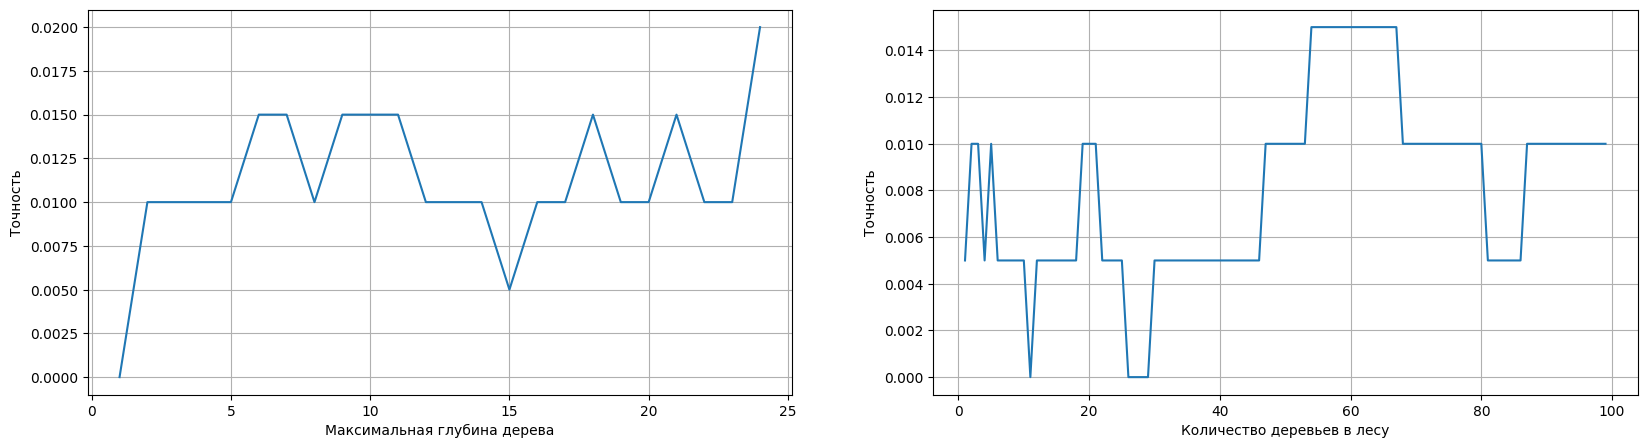

In [144]:
md = 25
ne = 100

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

y_max_depth = []
y_n_estimators = []
for max_depth in range(1, md):
    y_max_depth.append(get_score(rawImages_tr, rawImages_tst,
                                 labels_train, labels_test, max_depth))
axs[0].plot(range(1, md), y_max_depth)
axs[0].set_ylabel("Точность")
axs[0].set_xlabel("Максимальная глубина дерева")
axs[0].grid(True)
max_depth = np.argmax(y_max_depth) + 1

for n_estimators in range(1, ne):
    y_n_estimators.append(get_score(rawImages_tr, rawImages_tst,
                                    labels_train, labels_test, 
                                    max_depth, n_estimators))
axs[1].plot(range(1, ne), y_n_estimators)
axs[1].set_ylabel("Точность")
axs[1].set_xlabel("Количество деревьев в лесу")
axs[1].grid(True)
n_estimators = np.argmax(y_n_estimators) + 1

plt.show()

(100, 100)
estimators=50, max_depth=20
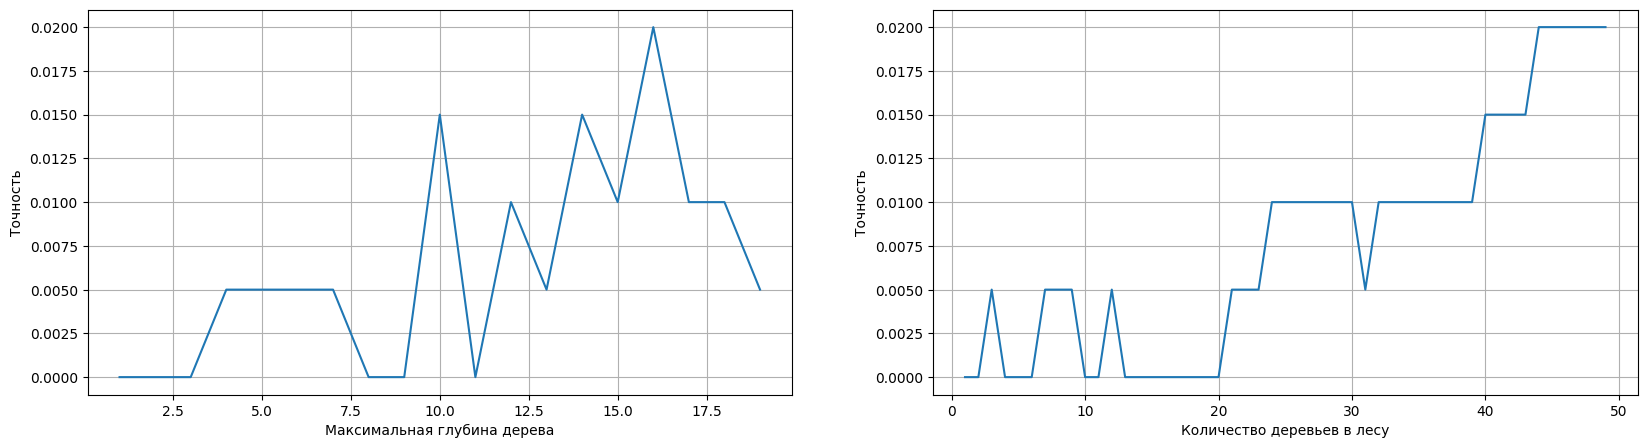

### то же самое на sci-kit learn Digits

In [11]:
from sklearn.datasets import load_digits

In [14]:
X, Y = load_digits(return_X_y=True)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

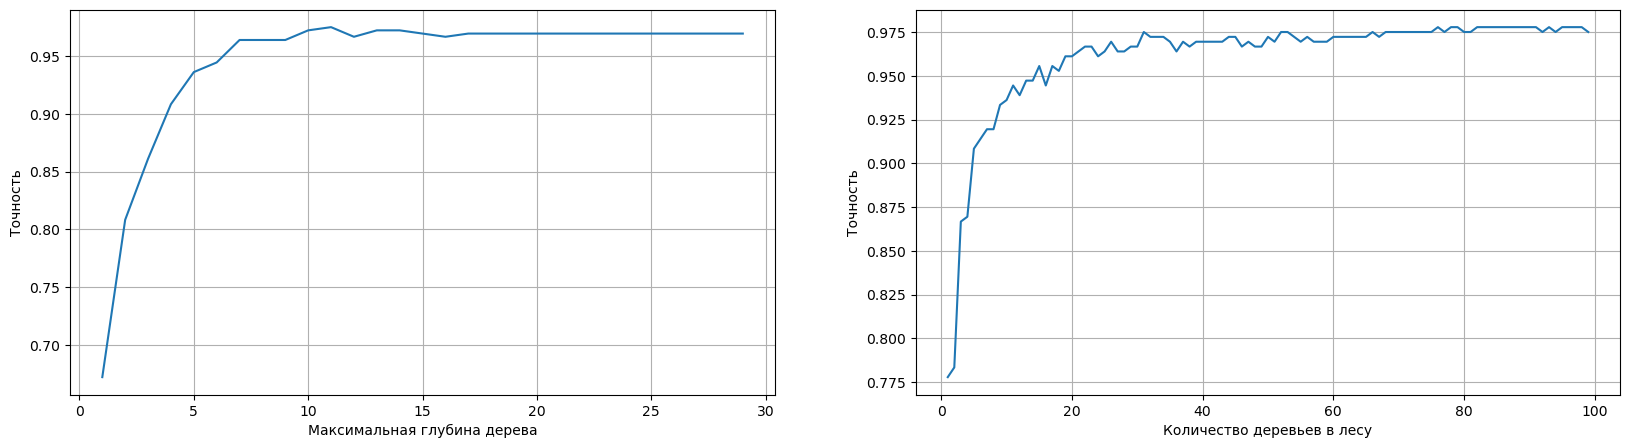

In [15]:
md = 30
ne = 100

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

y_max_depth = []
y_n_estimators = []
for max_depth in range(1, md):
    y_max_depth.append(get_score(X_train, X_test,
                                 Y_train, Y_test, max_depth))
axs[0].plot(range(1, md), y_max_depth)
axs[0].set_ylabel("Точность")
axs[0].set_xlabel("Максимальная глубина дерева")
axs[0].grid(True)
max_depth = np.argmax(y_max_depth) + 1

for n_estimators in range(1, ne):
    y_n_estimators.append(get_score(X_train, X_test,
                                    Y_train, Y_test,
                                    max_depth, n_estimators))
axs[1].plot(range(1, ne), y_n_estimators)
axs[1].set_ylabel("Точность")
axs[1].set_xlabel("Количество деревьев в лесу")
axs[1].grid(True)
n_estimators = np.argmax(y_n_estimators) + 1

plt.show()